In [165]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator

In [166]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)

In [167]:
tilt = config['tilt'] * degrees 
#clock = config['clock']
#beam_en = config['beam_enu0']
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
#tmat = pytpc.utilities.tilt_matrix(-tilt)
# efield_uvw = tmat.dot(efield)
# bfield_uvw = tmat.dot(bfield)
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
#beampads = np.fromfile(config['beampads_path'], sep=',', dtype='int')

In [211]:
#Good events for run_0102 are: 689 (fair ~37), 765 (good), 896 (good), 305 (perfect), 504 (not good ~65)
#575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485
full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
evt_ID = 485
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 150.0:
        del_list.append(i)
cut_xyzs = np.delete(xyzs,del_list,axis=0)

In [212]:
######finding center of curvature
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
print(cx,cy) #The center of curvature of the track, in mm.

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

76.86319451973847 -117.01303059155782


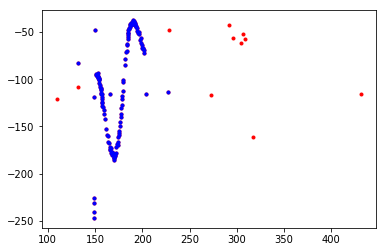

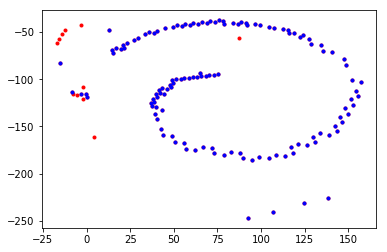

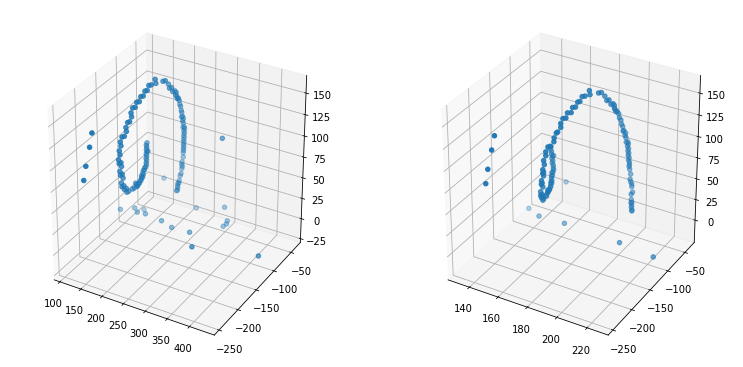

In [213]:
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0])

<IPython.core.display.Javascript object>


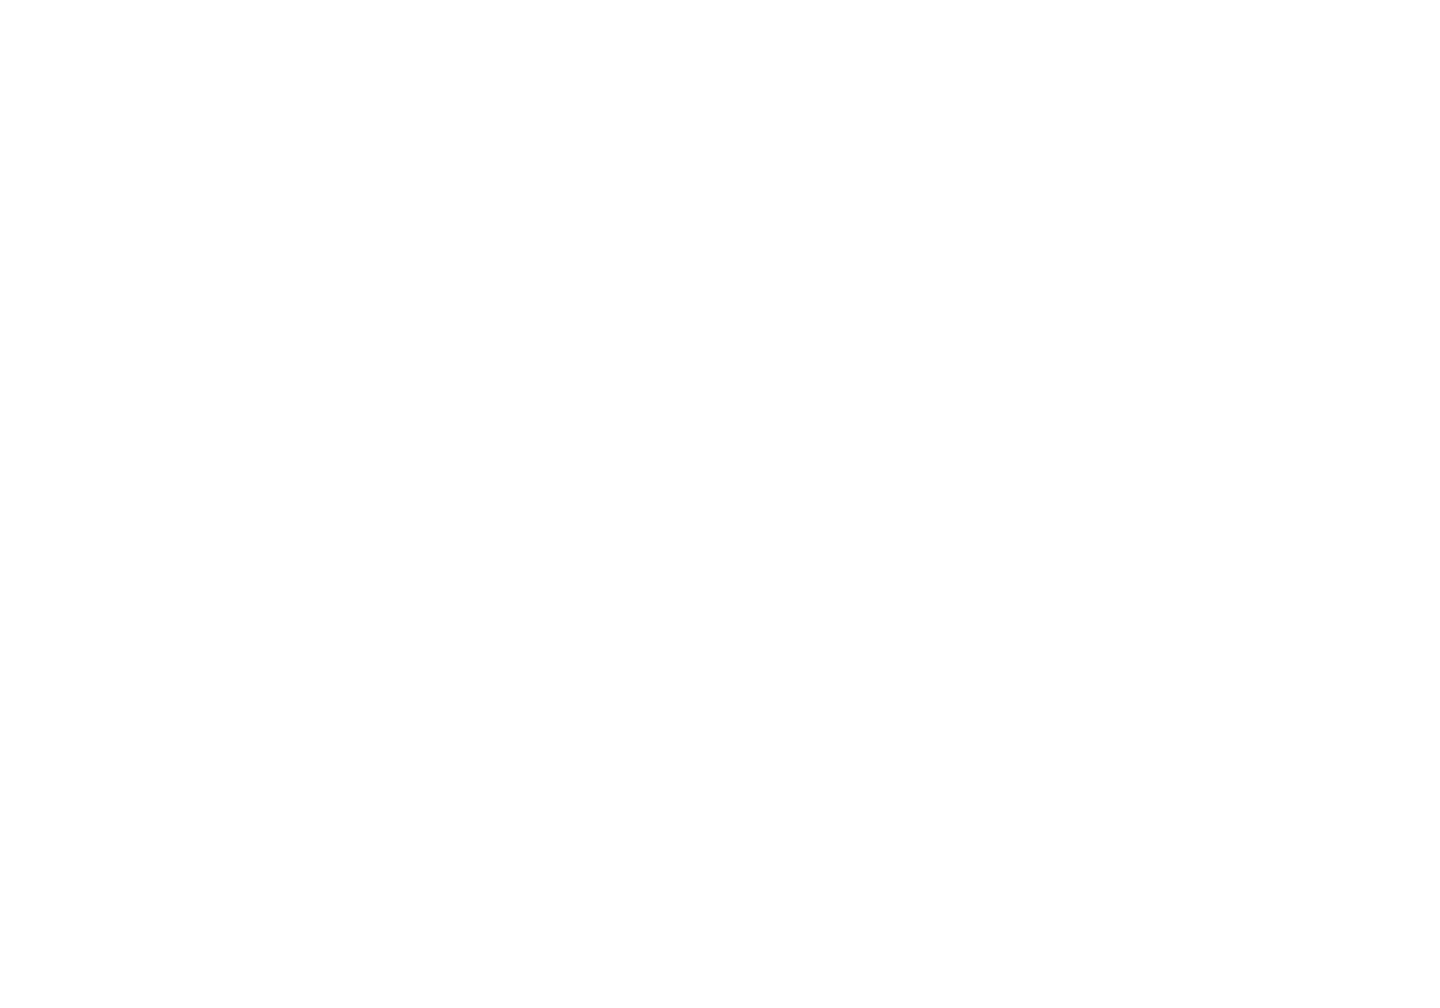

<IPython.core.display.Javascript object>


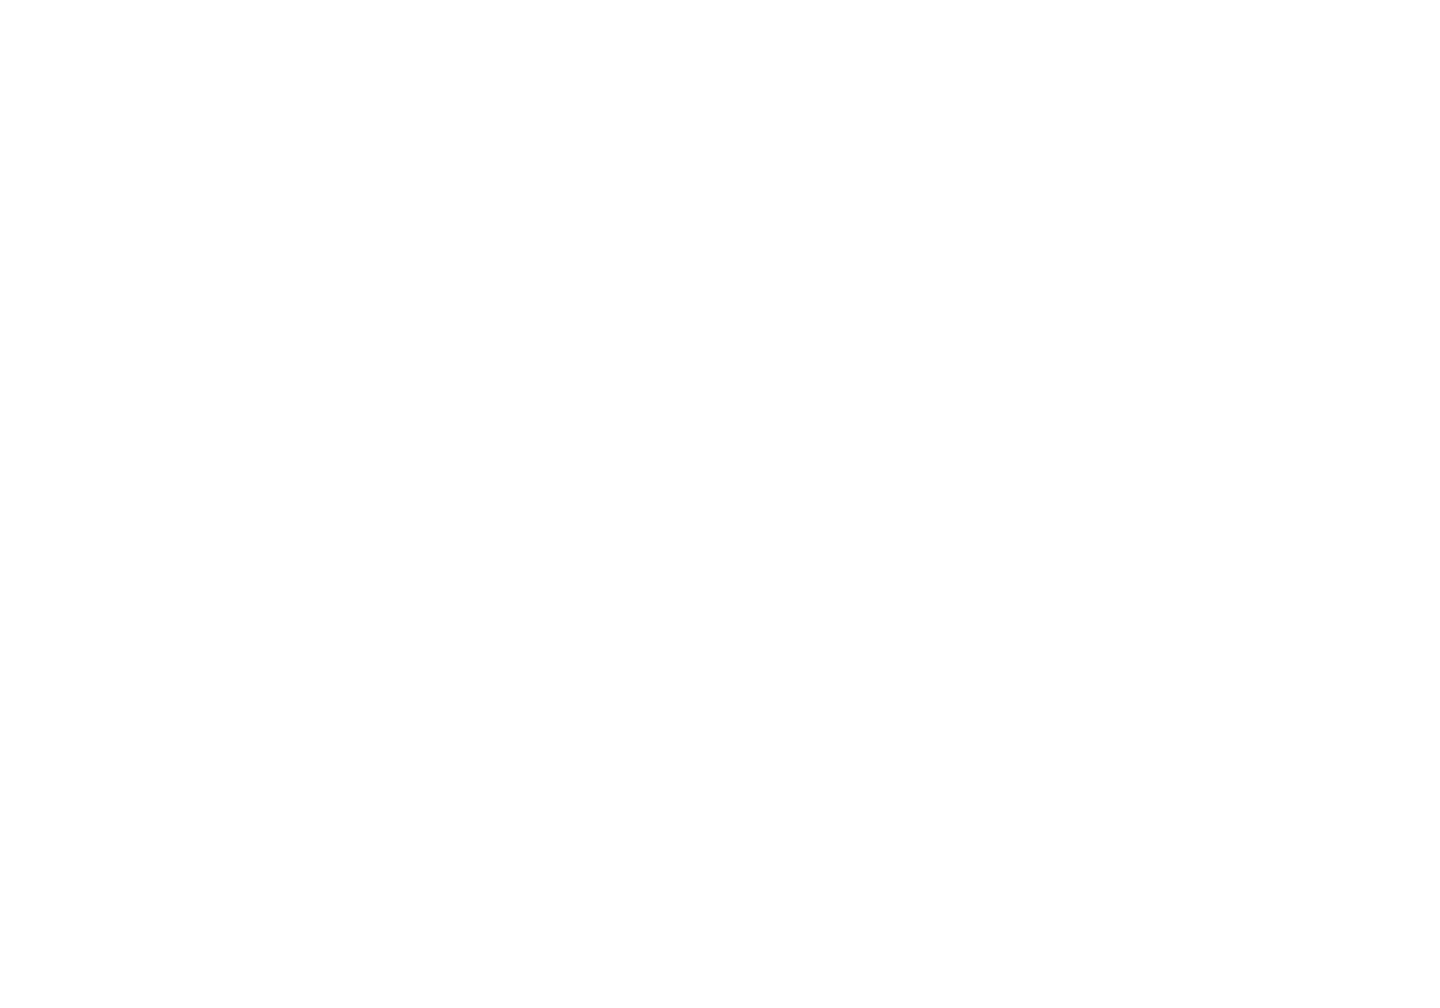

In [183]:
%matplotlib notebook
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0], c='r')
ax.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0], c='b')

In [219]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False) # get calibrated set of data
uvw_values = uvw.values #transform pd file to arrays
mcres, minChis, all_params, good_param_idx = mcfitter.process_event(uvw, cu, cv, return_details=True)

print(mcres)

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
cut_uvw_values = cut_uvw.values #transform pd file to arrays
cut_mcres, cut_minChis, cut_all_params, cut_good_param_idx = mcfitter.process_event(cut_uvw, cut_cu, cut_cv, return_details=True)
print(cut_mcres)

{'x0': 0.008218943384604471, 'y0': -0.0036221210221014256, 'z0': 0.24651318110485762, 'enu0': 3.3771524465482012, 'azi0': 1.0922601462440718, 'pol0': 0.6549814593702271, 'posChi2': 76.85704508102963, 'enChi2': 14.00087093345848, 'vertChi2': 1.6134158211616534, 'lin_scat_ang': 2.3165044893702738, 'lin_beam_int': 296.1693358162251, 'lin_chi2': 2444.282681273381, 'rad_curv': 74.14738489929682, 'brho': 0.16957026578568044, 'curv_en': 1.3771524465482012, 'curv_ctr_x': 76.86319451973847, 'curv_ctr_y': -7.693852803315593}
{'x0': 0.00031921241591413606, 'y0': 0.008906166866628477, 'z0': 0.403462298642548, 'enu0': 1.3755793196238006, 'azi0': 1.233538034114813, 'pol0': 1.7799412202866478, 'posChi2': 8.160921803350591, 'enChi2': 14.470076841182664, 'vertChi2': 1.5884340964540928, 'lin_scat_ang': 1.3417726481544283, 'lin_beam_int': 407.08642151889944, 'lin_chi2': 0.9622350061293155, 'rad_curv': 73.78755897021034, 'brho': 0.12728674562430614, 'curv_en': 0.7759772377774712, 'curv_ctr_x': 78.69167289

In [220]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(mcres['x0'], mcres['y0'], mcres['z0'], mcres['enu0'], mcres['azi0'], mcres['pol0'])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
# drift_vel=-2.54, clock=12.5, 

cut_evtClean, cut_ctr = sim.make_event(cut_mcres['x0'], cut_mcres['y0'], cut_mcres['z0'], cut_mcres['enu0'], cut_mcres['azi0'], cut_mcres['pol0'])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [221]:
#treating the simulated data (starts with sim) as input, and run the fitting algorithm to see if we get the same parameters
#as the ones we used to generate the data.

sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values


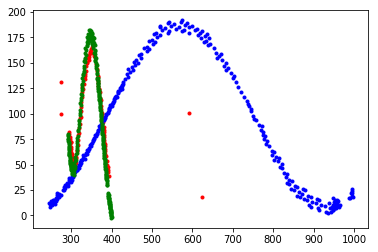

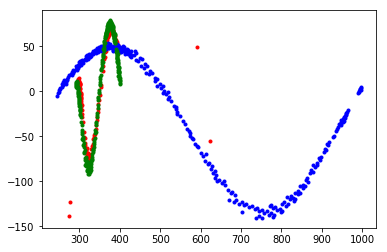

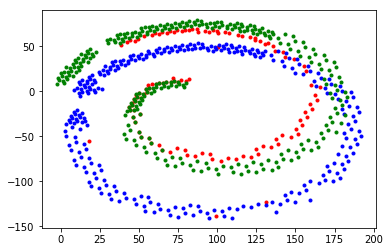

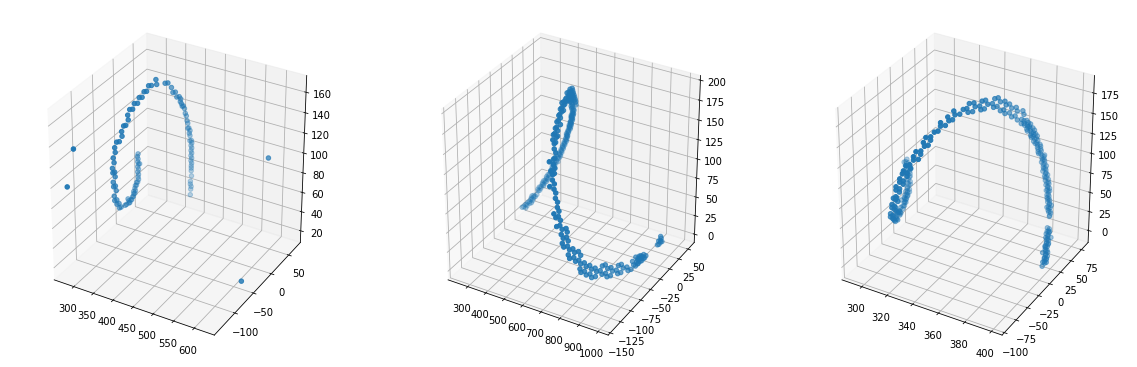

In [222]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])



<IPython.core.display.Javascript object>


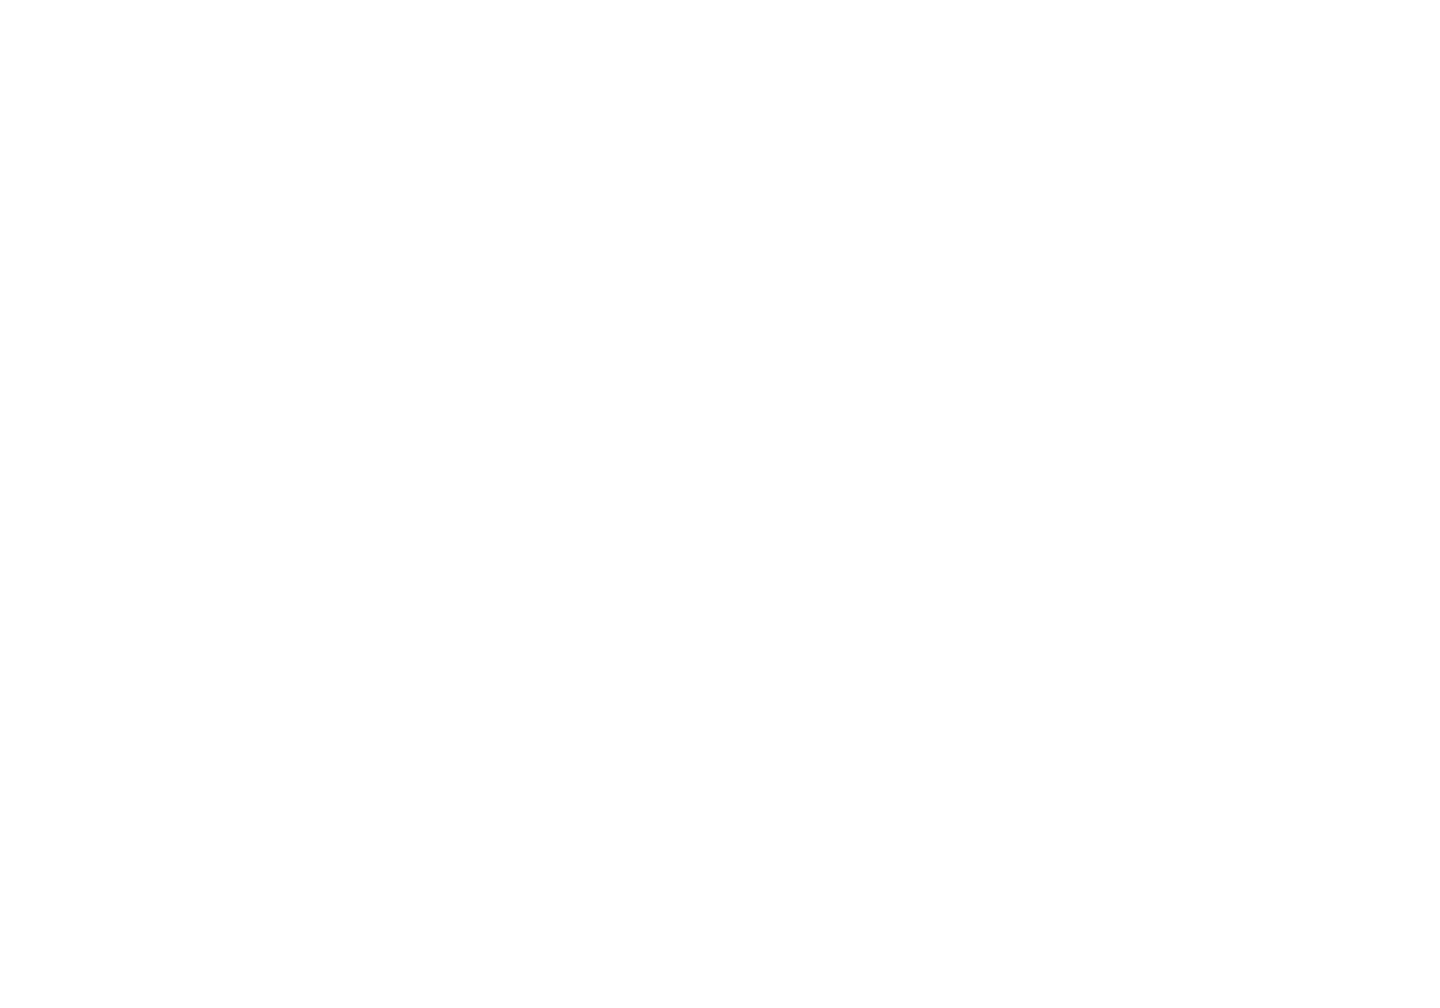

<IPython.core.display.Javascript object>


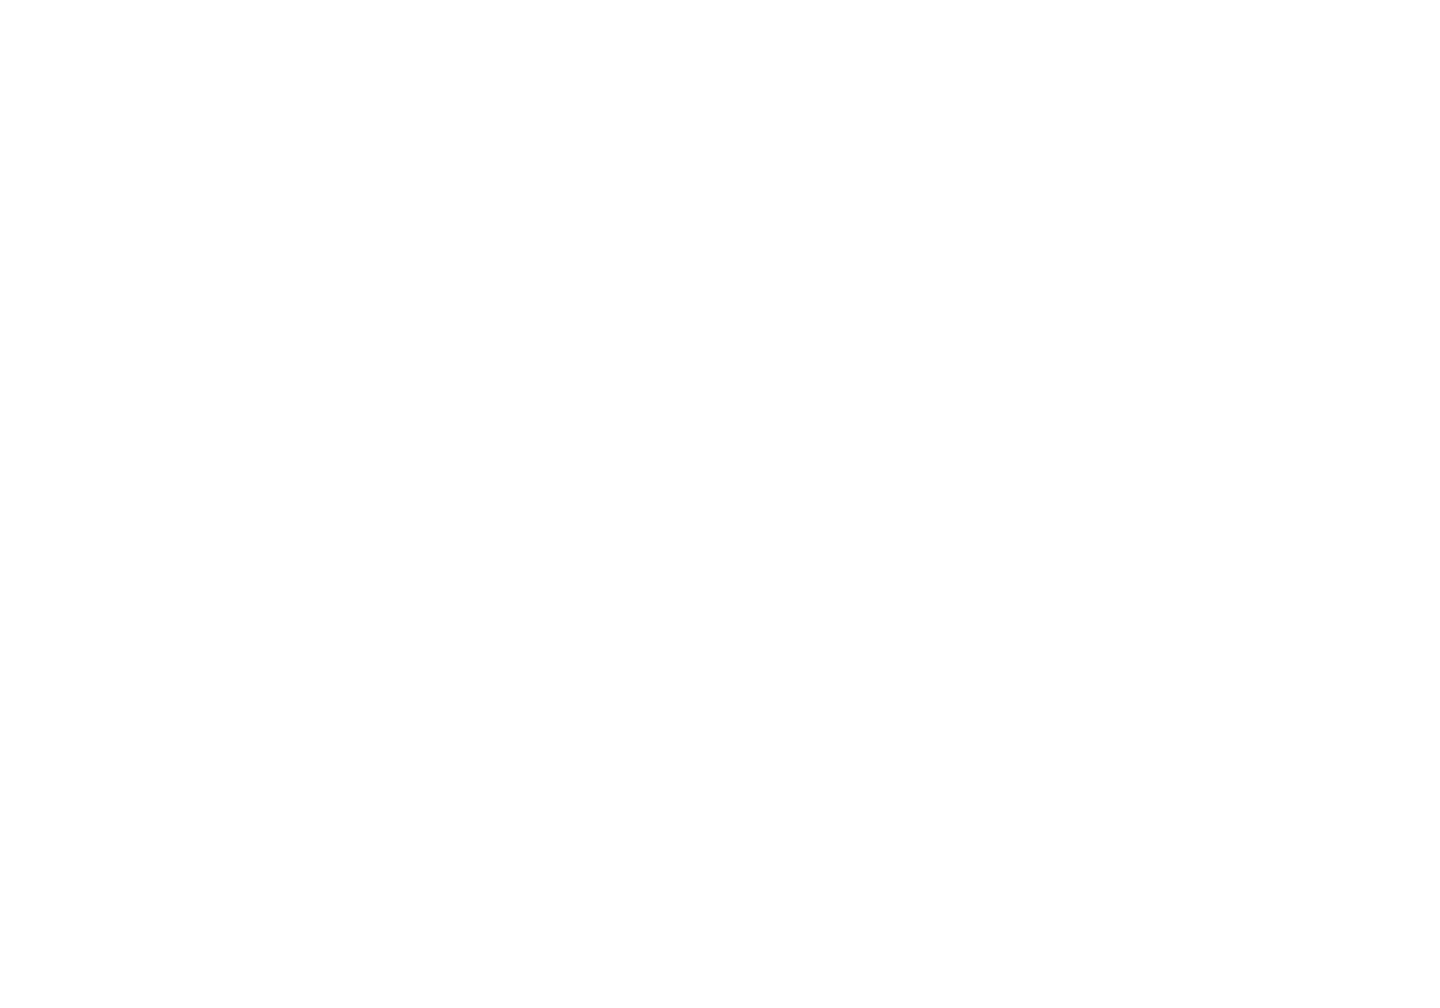

In [234]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r')
ax.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5],c='b')
ax.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5],c='g')


In [224]:
good_params = all_params[good_param_idx.astype('int')] #the best points from each iteration, i.e. the ones whose
#                                                       chi2 values are in ``min_chis``
all_params = all_params.reshape((mcfitter.num_iters, mcfitter.num_pts, 6))

In [ ]:
print(minChis)
#print(good_params)
plt.plot(minChis, 'o-')
plt.plot(minChis.sum(1))
plt.semilogy()
plt.legend(('pos', 'en', 'vert'))
#plt.ylim(1e-6,1e3)

In [ ]:
#print(good_params)
params_name = ['x', 'y', 'z', 'en', 'azi', 'pol']

for v, l in zip(good_params.T, range(len(params_name))):
    plt.plot(v, label=l)
    plt.legend(params_name[l])
    plt.title('parameter: ' + str(params_name[l]))
    plt.show()
    
for v, l in zip(good_params.T, params_name):
    plt.plot(v, label=l)
plt.legend(loc=4)
plt.title("parameters' value through each iteration")
plt.show()
    
for v, l in zip(good_params.T, params_name):    
    plt.plot(v / v[0], label=l)
plt.title("parameters' value with respect to their initial value")
plt.legend(loc=4)

In [ ]:

plt.figure(figsize=(3.5, 2.5))
plt.plot(all_params[:, :, 3].ravel(), ',')
plt.xticks(np.arange(0, mcfitter.num_pts * (mcfitter.num_iters + 1), mcfitter.num_pts * 5),
               np.arange(0, mcfitter.num_iters + 1, 5))

plt.xlabel('Iteration number')
plt.ylabel('Proton energy [MeV]')
    
plt.tight_layout(pad=0.5)
plt.subplots_adjust(right=0.9)
    
plt.xlim(0)
plt.ylim(0)


In [ ]:
tracker = Tracker(mass_num, charge_num, beam_enu0, beam_mass, beam_charge, gas, efield, bfield, max_en) 
evtgen = EventGenerator(padplane, vd, 12.5, 280e-9, mass_num, 23.0, 500, 120e-15, tilt, 0.1e-3) 


num_iters = [5, 10, 15, 20]
num_pts = [100, 200, 300, 400, 500] #repeat(200)
red_factor = [0.5, 0.6, 0.7, 0.8, 0.9]

#for n, p, r in zip(num_iters, num_pts, red_factor):
#    minimizer = Minimizer(tracker, evtgen, num_iters, num_pts, red_factor)

allctrs = []
for n, p, r in zip(num_iters, num_pts, red_factor):
    ctrs = []
    for i in range(1):
        mcres, minChis, all_params, good_param_idx = mcfitter.process_event(uvw, cu, cv, return_details=True)
        good_params = all_params[good_param_idx.astype('int')]
        ctrs.append(pd.DataFrame(good_params.T, index=('x', 'y', 'z', 'en', 'azi', 'pol')))

    ctrs = pd.concat(ctrs, axis=1).T
    ctrs['num_iters'] = n
    ctrs['num_pts'] = p
    ctrs['red_factor'] = r

    allctrs.append(ctrs)